# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1187,sport,newcastle to join morientes race newcastle hav...
1986,politics,uk set to cut back on embassies nine overseas ...
1593,sport,farrell saga to drag on - lindsay wigan chairm...
855,business,japan bank shares up on link talk shares of su...
1902,politics,labour trio had vote-rig factory three labou...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
bbc.isnull().sum()

category    0
text        0
dtype: int64

In [6]:
len(bbc)

2225

In [7]:
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

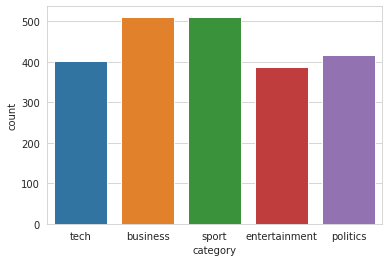

In [8]:
sns.countplot(x="category", data=bbc)

In [9]:
train_size = int(len(bbc) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(bbc) - train_size))

Train size: 1780
Test size: 445


### Data preparation
There's some work to be done in order for our data to be ready for training.
1. First we'll split the data into training and test sets.
2. Then we'll tokenize the words (text), and then convert them to a numbered index.
3. Next we'll do the same for the labels (categories), by using the LabelEncoder utility.
4. Finally, we'll convert the labels to a one-hot representation.

In [10]:
def train_test_split(bbc, train_size):
    train = bbc[:train_size]
    test = bbc[train_size:]
    return train, test
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
layers = keras.layers
models = keras.models

from tensorflow import keras
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [11]:
train_cat, test_cat = train_test_split(bbc['category'], train_size)
train_text, test_text = train_test_split(bbc['text'], train_size)

In [12]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [13]:
#Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


### Train the model
Build the model using Keras layers and hyperparameters of your choosing. Then call model.fit()

In [15]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 10
epochs = 15
drop_ratio = 0.5
# Build the model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(1000,)))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/15
161/161 [==============================] - 1s 5ms/step - loss: 0.2976 - accuracy: 0.9182 - val_loss: 0.1399 - val_accuracy: 0.9663
Epoch 2/15
161/161 [==============================] - 1s 4ms/step - loss: 0.0159 - accuracy: 0.9988 - val_loss: 0.1220 - val_accuracy: 0.9607
Epoch 3/15
161/161 [==============================] - 1s 4ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1178 - val_accuracy: 0.9607
Epoch 4/15
161/161 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1178 - val_accuracy: 0.9607
Epoch 5/15
161/161 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 0.9607
Epoch 6/15
161/161 [==============================] - 1s 4ms/step - loss: 7.5204e-04 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9607
Epoch 7/15
161/161 [==============================] - 1s 4ms/step - loss: 5.1054e-04 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.960

### Evaluate the model

In [17]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9640
Test loss: 0.1471831202507019
Test accuracy: 0.9640449285507202


### Hyperparameter tuning
This is a good time to go back and tweak some parameters such as epoch, batch size, dropout ratio, network structure, activation function, and others, to see if you can improve the accuracy.

In this particular case, to make it more challenging, I recommend reducing the max words of the call to keras.preprocessing.text.Tokenizer. This will reduce the number of words for each input sample, thus making it more challenging to accurately predict the category. (Notice that not all hyperparameters are necessarily inside the model. This is one such example.)

The default was up to 1000 words per article. See what happens when you reduce that number to 200 words, or 50 words, or even fewer. As the evaluation accuracy drops, the effects of your hyperparameter tuning will be more pronounced, with successful adjustments making meaningful improvements to the model performance.

To make this process easier to manage, I've encapulated the model definition and training and evaluation calls into one function call. You can add additional parameters as needed.

In [18]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [19]:
max_words = 1000
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.1337822824716568
	Test accuracy: 0.9573033452033997


In [20]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: tech

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business

fast lifts rise into record books two high-speed l ...
Actual label:tech
Predicted label: business

muslim group attacks tv drama 24 a british muslim  ...
Actual label:entertainment
Predicted label: entertainment

us tv special for tsunami relief a us television n ...
Actual label:entertai

In [21]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [22]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

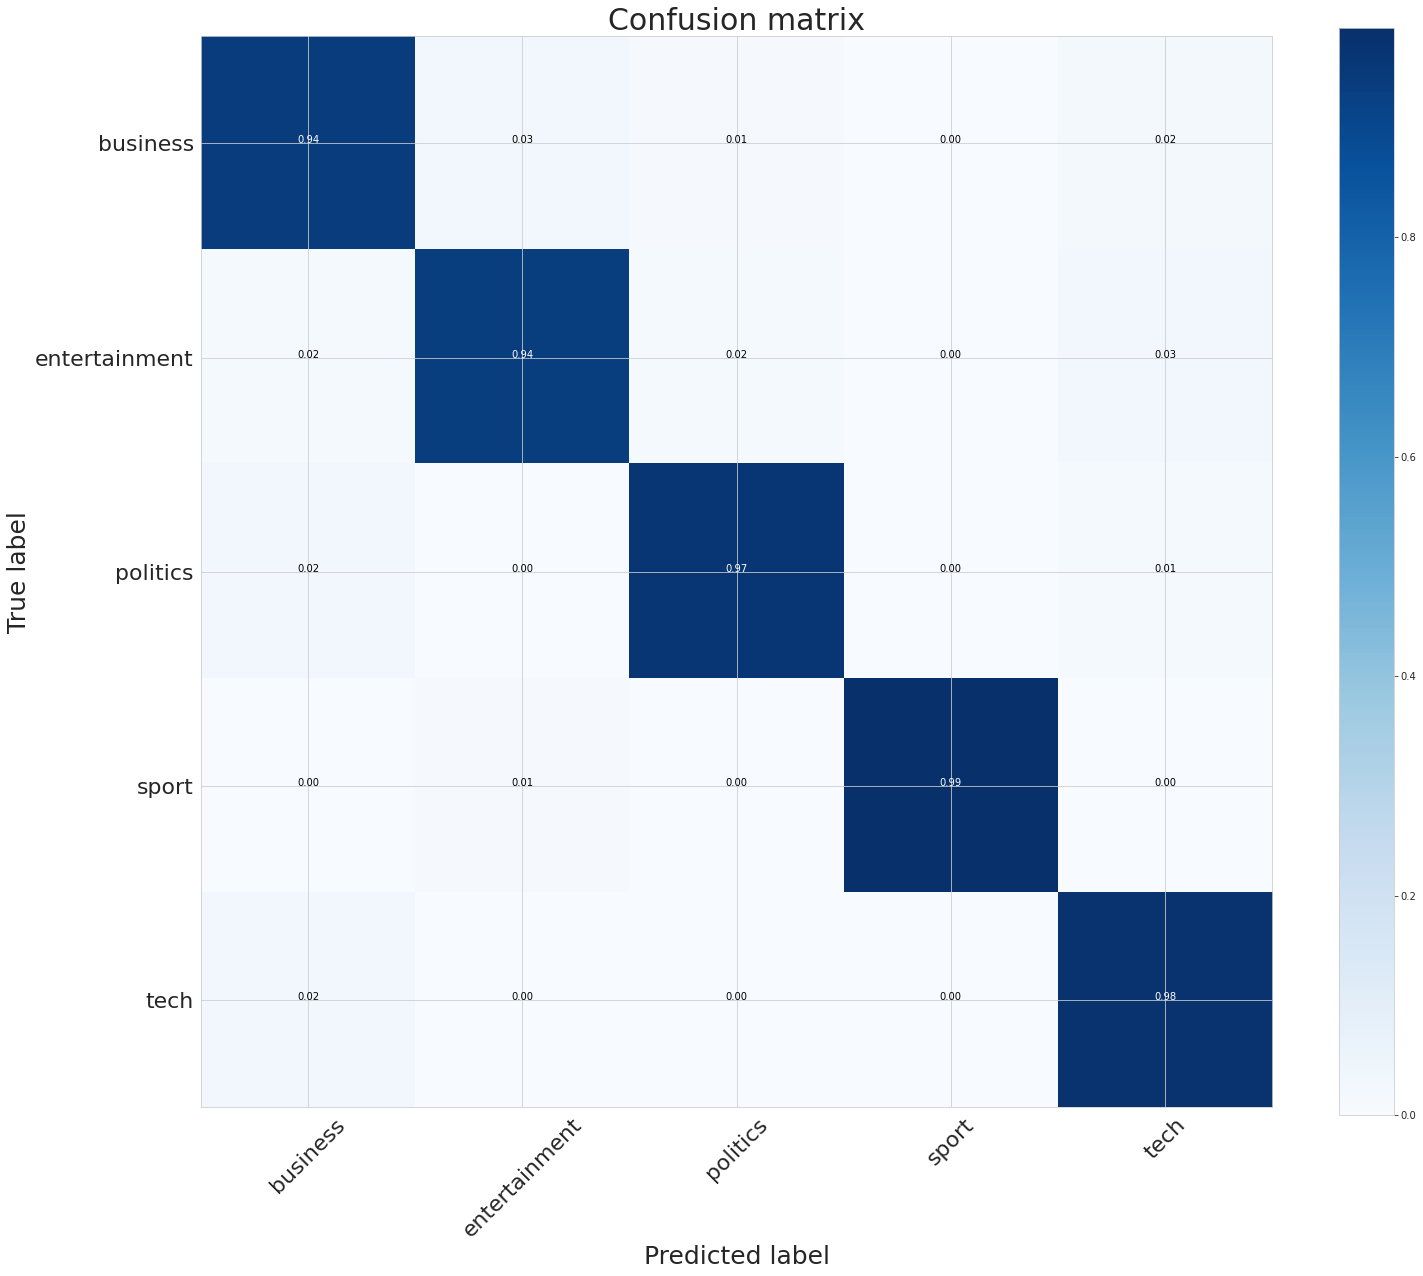

In [23]:
import itertools
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()